**Library Import**

In [11]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


**MNIST Dataset Loading**

In [12]:
# Load MNIST without normalization
raw_transform = transforms.ToTensor()  

train_dataset_raw = datasets.MNIST(root="./data", train=True, transform=raw_transform, download=True)
test_dataset_raw = datasets.MNIST(root="./data", train=False, transform=raw_transform, download=True)

# Calculation of mean and standard deviation for normalization purpose
X_train_raw = train_dataset_raw.data.numpy().astype('float32') / 255.0
y_train = train_dataset_raw.targets.numpy()
X_test_raw = test_dataset_raw.data.numpy().astype('float32') / 255.0
y_test = test_dataset_raw.targets.numpy()

X_train = X_train_raw.reshape(len(X_train_raw), -1)
X_test = X_test_raw.reshape(len(X_test_raw), -1)

mean = X_train.mean()
std = X_train.std()
print(f"Computed Mean: {mean:.4f}, Std: {std:.4f}")

# Normalized MNIST
normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=normalized_transform, download=False)
test_dataset = datasets.MNIST(root="./data", train=False, transform=normalized_transform, download=False)

print("Training data shape:", X_train.shape, "Labels shape:", y_train.shape)
print("Test data shape:", X_test.shape, "Labels shape:", y_test.shape)


Computed Mean: 0.1307, Std: 0.3081
Training data shape: (60000, 784) Labels shape: (60000,)
Test data shape: (10000, 784) Labels shape: (10000,)


**Function of Computation of PCA and LDA**

In [13]:
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X_train), pca.transform(X_test)

def apply_lda(X_train, y_train, X_test, n_components):
    lda = LDA(n_components=n_components)
    return lda.fit_transform(X_train, y_train), lda.transform(X_test)

**Mahalanobis Classifier Function**

In [14]:
class MahalanobisClassifier:
    def fit(self, X, y):
        X = np.atleast_2d(X)
        self.classes_ = np.unique(y)
        self.class_means_ = {c: X[y == c].mean(axis=0) for c in self.classes_}
        cov_matrix = np.cov(X, rowvar=False, ddof=0)
        if cov_matrix.ndim == 0:
            self.inv_cov_ = 1 / (cov_matrix + 1e-6)
        else:
            self.inv_cov_ = np.linalg.pinv(cov_matrix + 1e-6 * np.eye(cov_matrix.shape[0]))
        return self

    def predict(self, X):
        X = np.atleast_2d(X)
        y_pred = []
        for x in X:
            distances = [np.dot(np.dot((x - self.class_means_[c]), self.inv_cov_), (x - self.class_means_[c]).T) for c in self.classes_]
            y_pred.append(self.classes_[np.argmin(distances)])
        return np.array(y_pred)

    def score(self, X, y_true):
        return np.mean(self.predict(X) == y_true)

**Experimental Training**

In [15]:
# Define of PCA and LDA possible value and results storage
pca_components_list = list(range(1, 785, 10)) + [784]
lda_components_list = list(range(1, 10)) 

results_pca = {"Components": [], "Mahalanobis": [], "Logistic Regression": [], "k-NN": []}
results_lda = {"Components": [], "Mahalanobis": [], "Logistic Regression": [], "k-NN": []}
results_pca_lda = {"PCA Components": [], "LDA Components": [], "Mahalanobis": [], "Logistic Regression": [], "k-NN": []}
results_lda_pca = {"PCA Components": [], "LDA Components": [], "Mahalanobis": [], "Logistic Regression": [], "k-NN": []}

# Test PCA
for n_comp in pca_components_list:
    print("Testing PCA n_comp = " + str(n_comp))
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    mah_clf = MahalanobisClassifier().fit(X_train_pca, y_train)
    log_clf = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial').fit(X_train_pca, y_train)
    knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_pca, y_train)

    results_pca["Components"].append(n_comp)
    results_pca["Mahalanobis"].append(mah_clf.score(X_test_pca, y_test))
    results_pca["Logistic Regression"].append(log_clf.score(X_test_pca, y_test))
    results_pca["k-NN"].append(knn_clf.score(X_test_pca, y_test))

# Test LDA
for n_comp in lda_components_list:
    print("Testing LDA n_comp = " + str(n_comp))
    lda = LDA(n_components=n_comp)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    mah_clf = MahalanobisClassifier().fit(X_train_lda, y_train)
    log_clf = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial').fit(X_train_lda, y_train)
    knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_lda, y_train)

    results_lda["Components"].append(n_comp)
    results_lda["Mahalanobis"].append(mah_clf.score(X_test_lda, y_test))
    results_lda["Logistic Regression"].append(log_clf.score(X_test_lda, y_test))
    results_lda["k-NN"].append(knn_clf.score(X_test_lda, y_test))

# Test PCA -> LDA
for pca_comp in pca_components_list:
    pca = PCA(n_components=pca_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    max_lda_components = min(pca_comp, 9) 

    for lda_comp in range(1, max_lda_components + 1): 
        print("Testing PCA -> LDA n_comp = " + str(pca_comp) + ", " + str(lda_comp))
        try:
            lda = LDA(n_components=lda_comp)
            X_train_pca_lda = lda.fit_transform(X_train_pca, y_train)
            X_test_pca_lda = lda.transform(X_test_pca)

            mah_clf = MahalanobisClassifier().fit(X_train_pca_lda, y_train)
            log_clf = LogisticRegression(max_iter=500, solver='lbfgs').fit(X_train_pca_lda, y_train)
            knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_pca_lda, y_train)

            results_pca_lda["PCA Components"].append(pca_comp)
            results_pca_lda["LDA Components"].append(lda_comp)
            results_pca_lda["Mahalanobis"].append(mah_clf.score(X_test_pca_lda, y_test))
            results_pca_lda["Logistic Regression"].append(log_clf.score(X_test_pca_lda, y_test))
            results_pca_lda["k-NN"].append(knn_clf.score(X_test_pca_lda, y_test))

        # Skip this iteration if LDA fails
        except np.linalg.LinAlgError:
            print(f"⚠️ SVD did not converge for PCA={pca_comp}, LDA={lda_comp} → Skipping!")
            continue  

# Test LDA -> PCA
for lda_comp in lda_components_list:  
    try:
        lda = LDA(n_components=lda_comp)
        X_train_lda = lda.fit_transform(X_train, y_train)
        X_test_lda = lda.transform(X_test)

        for pca_comp in range(1, lda_comp + 1):  
            print("Testing LDA -> PCA n_comp = " + str(lda_comp) + ", " + str(pca_comp))

            pca = PCA(n_components=pca_comp)
            X_train_lda_pca = pca.fit_transform(X_train_lda)
            X_test_lda_pca = pca.transform(X_test_lda)

            mah_clf = MahalanobisClassifier().fit(X_train_lda_pca, y_train)
            log_clf = LogisticRegression(max_iter=500, solver='lbfgs').fit(X_train_lda_pca, y_train)
            knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_lda_pca, y_train)

            # Store results
            results_lda_pca["LDA Components"].append(lda_comp)
            results_lda_pca["PCA Components"].append(pca_comp)
            results_lda_pca["Mahalanobis"].append(mah_clf.score(X_test_lda_pca, y_test))
            results_lda_pca["Logistic Regression"].append(log_clf.score(X_test_lda_pca, y_test))
            results_lda_pca["k-NN"].append(knn_clf.score(X_test_lda_pca, y_test))

    except np.linalg.LinAlgError:
        print(f"⚠️ SVD did not converge for LDA={lda_comp} → Skipping!")
        continue


Testing PCA n_comp = 1
Testing PCA n_comp = 11
Testing PCA n_comp = 21
Testing PCA n_comp = 31
Testing PCA n_comp = 41
Testing PCA n_comp = 51
Testing PCA n_comp = 61
Testing PCA n_comp = 71
Testing PCA n_comp = 81
Testing PCA n_comp = 91
Testing PCA n_comp = 101
Testing PCA n_comp = 111
Testing PCA n_comp = 121
Testing PCA n_comp = 131
Testing PCA n_comp = 141
Testing PCA n_comp = 151
Testing PCA n_comp = 161
Testing PCA n_comp = 171
Testing PCA n_comp = 181
Testing PCA n_comp = 191
Testing PCA n_comp = 201
Testing PCA n_comp = 211
Testing PCA n_comp = 221
Testing PCA n_comp = 231
Testing PCA n_comp = 241
Testing PCA n_comp = 251
Testing PCA n_comp = 261
Testing PCA n_comp = 271
Testing PCA n_comp = 281
Testing PCA n_comp = 291
Testing PCA n_comp = 301
Testing PCA n_comp = 311
Testing PCA n_comp = 321
Testing PCA n_comp = 331
Testing PCA n_comp = 341
Testing PCA n_comp = 351
Testing PCA n_comp = 361
Testing PCA n_comp = 371
Testing PCA n_comp = 381
Testing PCA n_comp = 391
Testing PCA

**Get the Best Component Number for Best Model in terms of Accuracy for All 4 Method**

In [16]:
# Function to get the best accuracy and corresponding components
def get_best_accuracy(results_dict, method_name):
    best_idx_mahal = np.argmax(results_dict["Mahalanobis"])
    best_idx_logistic = np.argmax(results_dict["Logistic Regression"])
    best_idx_knn = np.argmax(results_dict["k-NN"])

    best_mahalanobis = results_dict["Mahalanobis"][best_idx_mahal]
    best_logistic = results_dict["Logistic Regression"][best_idx_logistic]
    best_knn = results_dict["k-NN"][best_idx_knn]

    best_comp_mahal = results_dict["Components"][best_idx_mahal] if "Components" in results_dict else (results_dict["PCA Components"][best_idx_mahal], results_dict["LDA Components"][best_idx_mahal])
    best_comp_logistic = results_dict["Components"][best_idx_logistic] if "Components" in results_dict else (results_dict["PCA Components"][best_idx_logistic], results_dict["LDA Components"][best_idx_logistic])
    best_comp_knn = results_dict["Components"][best_idx_knn] if "Components" in results_dict else (results_dict["PCA Components"][best_idx_knn], results_dict["LDA Components"][best_idx_knn])

    print(f"\n🔥 Best Accuracy for {method_name}:")
    print(f"   - Mahalanobis: {best_mahalanobis:.4f} at components {best_comp_mahal}")
    print(f"   - Logistic Regression: {best_logistic:.4f} at components {best_comp_logistic}")
    print(f"   - k-NN: {best_knn:.4f} at components {best_comp_knn}")

# Display best results at the end of execution
get_best_accuracy(results_pca, "PCA")
get_best_accuracy(results_lda, "LDA")
get_best_accuracy(results_pca_lda, "PCA -> LDA")
get_best_accuracy(results_lda_pca, "LDA -> PCA")



🔥 Best Accuracy for PCA:
   - Mahalanobis: 0.8677 at components 111
   - Logistic Regression: 0.9265 at components 761
   - k-NN: 0.9755 at components 31

🔥 Best Accuracy for LDA:
   - Mahalanobis: 0.8634 at components 8
   - Logistic Regression: 0.8866 at components 9
   - k-NN: 0.9144 at components 9

🔥 Best Accuracy for PCA -> LDA:
   - Mahalanobis: 0.8681 at components (191, 8)
   - Logistic Regression: 0.8912 at components (171, 9)
   - k-NN: 0.9201 at components (161, 9)

🔥 Best Accuracy for LDA -> PCA:
   - Mahalanobis: 0.8634 at components (8, 8)
   - Logistic Regression: 0.8866 at components (9, 9)
   - k-NN: 0.9144 at components (9, 9)


**Graphical Insight**

PCA

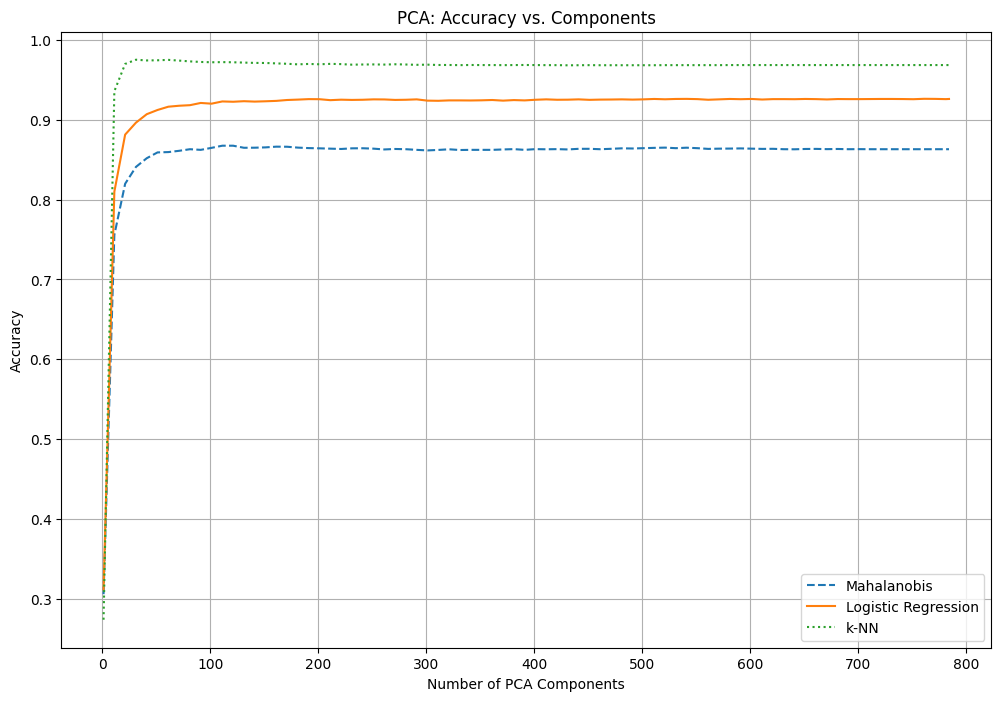

In [21]:
plt.figure(figsize=(12, 8))

plt.plot(results_pca["Components"], results_pca["Mahalanobis"], label="Mahalanobis", linestyle='dashed')
plt.plot(results_pca["Components"], results_pca["Logistic Regression"], label="Logistic Regression")
plt.plot(results_pca["Components"], results_pca["k-NN"], label="k-NN", linestyle='dotted')
plt.xlabel("Number of PCA Components")
plt.ylabel("Accuracy")
plt.title("PCA: Accuracy vs. Components")
plt.legend()
plt.grid(True)

plt.savefig("./Images/pca_accuracy_vs_components.png", dpi=300)
plt.show()

LDA

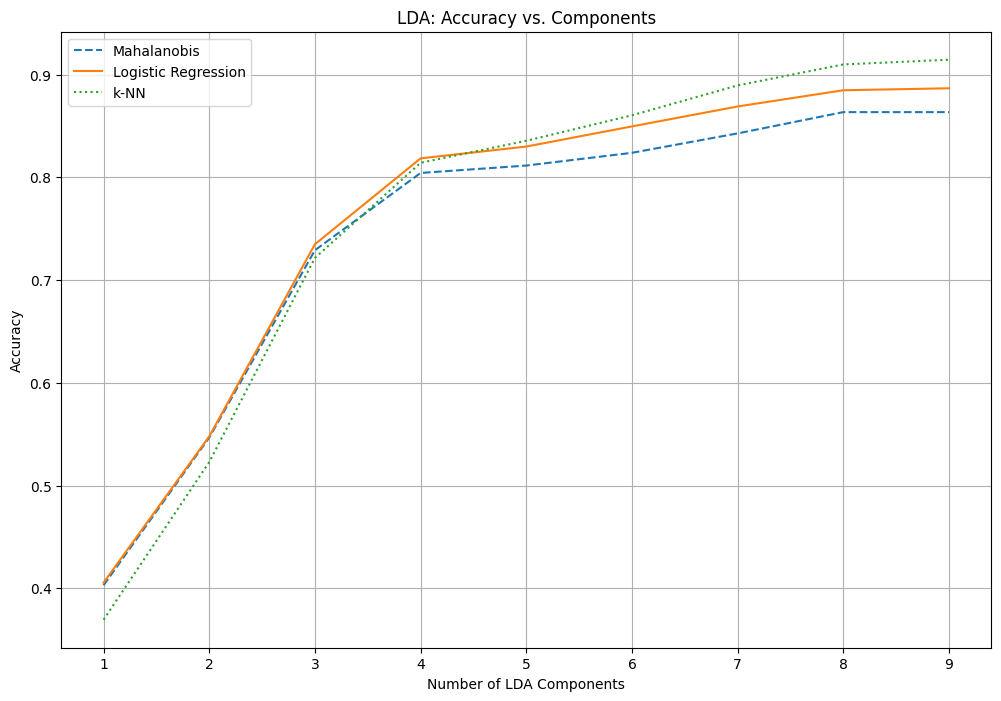

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(results_lda["Components"], results_lda["Mahalanobis"], label="Mahalanobis", linestyle='dashed')
plt.plot(results_lda["Components"], results_lda["Logistic Regression"], label="Logistic Regression")
plt.plot(results_lda["Components"], results_lda["k-NN"], label="k-NN", linestyle='dotted')
plt.xlabel("Number of LDA Components")
plt.ylabel("Accuracy")
plt.title("LDA: Accuracy vs. Components")
plt.legend()
plt.grid(True)

plt.savefig("./Images/lda_accuracy_vs_components.png", dpi=300)
plt.show()

PCA -> LDA

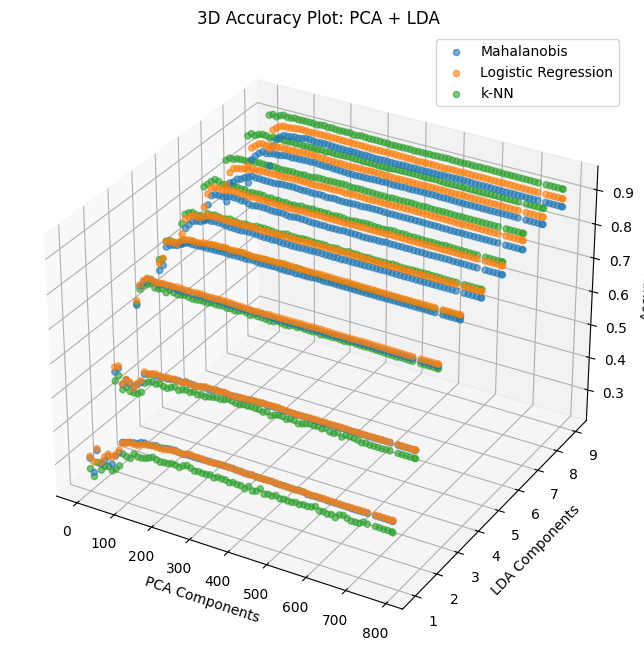

In [24]:
# Create 3D Plot
pca_lda = plt.figure(figsize=(12, 8))
ax = pca_lda.add_subplot(111, projection='3d')

# Plot each classifier's accuracy in 3D
ax.scatter(results_pca_lda["PCA Components"], results_pca_lda["LDA Components"], results_pca_lda["Mahalanobis"], label="Mahalanobis", alpha=0.6)
ax.scatter(results_pca_lda["PCA Components"], results_pca_lda["LDA Components"], results_pca_lda["Logistic Regression"], label="Logistic Regression", alpha=0.6)
ax.scatter(results_pca_lda["PCA Components"], results_pca_lda["LDA Components"], results_pca_lda["k-NN"], label="k-NN", alpha=0.6)

# Labels and title
ax.set_xlabel("PCA Components")
ax.set_ylabel("LDA Components")
ax.set_zlabel("Accuracy")
ax.set_title("3D Accuracy Plot: PCA + LDA")
ax.legend()

pca_lda.savefig("./Images/pca_lda_3d_accuracy_plot.png", dpi=300)

LDA -> PCA

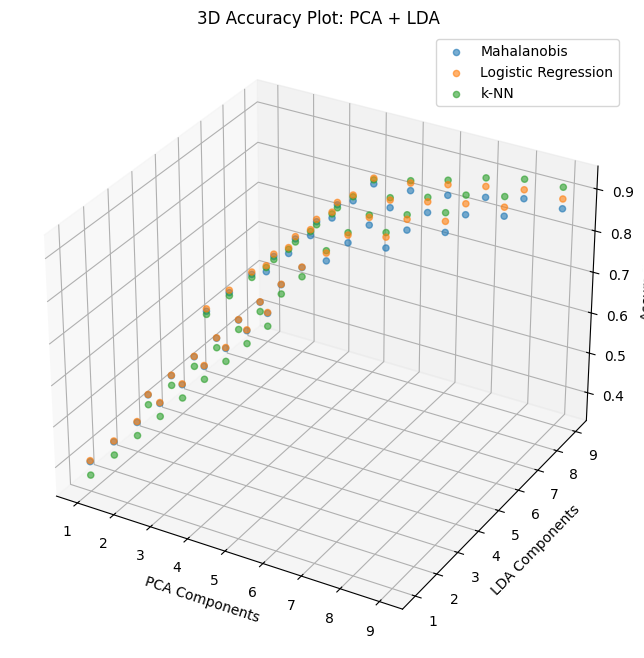

In [23]:
# Create 3D Plot
lda_pca = plt.figure(figsize=(12, 8))
ax = lda_pca.add_subplot(111, projection='3d')

# Plot each classifier's accuracy in 3D
ax.scatter(results_lda_pca["PCA Components"], results_lda_pca["LDA Components"], results_lda_pca["Mahalanobis"], label="Mahalanobis", alpha=0.6)
ax.scatter(results_lda_pca["PCA Components"], results_lda_pca["LDA Components"], results_lda_pca["Logistic Regression"], label="Logistic Regression", alpha=0.6)
ax.scatter(results_lda_pca["PCA Components"], results_lda_pca["LDA Components"], results_lda_pca["k-NN"], label="k-NN", alpha=0.6)

# Labels and title
ax.set_xlabel("PCA Components")
ax.set_ylabel("LDA Components")
ax.set_zlabel("Accuracy")
ax.set_title("3D Accuracy Plot: PCA + LDA")
ax.legend()

lda_pca.savefig("./Images/lda_pca_3d_accuracy_plot.png", dpi=300)